In [270]:
from abc import ABC, abstractmethod
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import poisson

In [271]:
class DiscreteEnvironment(ABC):
    
    @abstractmethod
    def step(self,action):
        pass
    
    @abstractmethod
    def reset(self):
        pass
    
class DiscreteAgent(ABC):
    @abstractmethod
    def __init__(self,env):
        pass
    
    @abstractmethod
    def update(self):
        pass
    
    @abstractmethod
    def get_action(self,state):
        pass

In [342]:
class GridWorld(DiscreteEnvironment):
    def __init__(self,r,c,num_goals,num_starts):
        self.maxrow = r
        self.maxcol = c
        self.tot_act = 4
        self.actions = [0,1,2,3]
        self.goal_states = []
        self.start_states = []
        self.vi_list = []
        self.pi_list = []
        self.num_goals = num_goals
        self.num_starts = num_starts
        self.reset()  
        
    def foul_state(self,row,col):
        if row < 0 or row >= self.maxrow or col < 0 or col >= self.maxcol:
            return True
        return False
    
    def goal_state(self):
        if (self.navigate_row,self.navigate_col) in self.goal_states:
            return True
        return False
        
    def step(self,action):
        row_copy = self.navigate_row
        col_copy = self.navigate_col
        
        #For value iteration.
        if self.goal_state():
            reward = 0
            done = True
            state = (self.navigate_row,self.navigate_col)
        else:
            if action == 0:
                self.navigate_row -= 1
            elif action == 1:
                self.navigate_row += 1
            elif action == 2:
                self.navigate_col -= 1
            elif action == 3:
                self.navigate_col += 1

            if self.foul_state(self.navigate_row,self.navigate_col): 
                reward = -20
                done = True
                state = (row_copy,col_copy)
                #print(state)
            elif self.goal_state():
                reward = 10
                done = True
                state = (self.navigate_row,self.navigate_col)
            else: 
                reward = -1
                done = False
                state = (self.navigate_row,self.navigate_col)
        
        return state,reward,done
    
    '''
    Used for dynamic programming methods where the start state is selected iteratively
    '''
    def set_start_state(self,state):
        self.navigate_row = state[0]
        self.navigate_col = state[1]
        
    '''
    Initialize random start and goal state
    '''
    def reset(self):
        
        #self.start_row = 0#random.randint(0,self.maxrow-1)
        #self.start_col = 0#random.randint(0,self.maxcol-1)
        #self.goal_row = [7,5,1,1]#random.randint(0,self.maxrow-1)
        #self.goal_col = [7,5,3,5]#random.randint(0,self.maxcol-1)
        #self.navigate_row = self.start_row
        #self.navigate_col = self.start_col
        for i in range(self.num_goals):
            a = random.randint(0,self.maxrow-1)
            b = random.randint(0,self.maxcol-1)
            self.goal_states.append((a,b))
        
        for i in range(self.num_starts):
            a = random.randint(0,self.maxrow-1)
            b = random.randint(0,self.maxcol-1)
            while (a,b) in self.goal_states:
                a = random.randint(0,self.maxrow-1)
                b = random.randint(0,self.maxcol-1)
            self.start_states.append((a,b))
        #self.goal_states.append((5,5))
        #self.goal_states.append((1,3))
        #self.goal_states.append((1,5))
    
    '''
    Under construction
    '''
    def vi_test(self,Q):
        N = self.num_starts
        return_val = 0
        for a,b in self.start_states:
            start_row = a#random.randint(0,self.maxrow-1)
            start_col = b#random.randint(0,self.maxcol-1)
            tot_iter = self.maxrow + self.maxcol - 1
            while tot_iter:
                state = (start_row,start_col)
                self.set_start_state(state)
                action = np.argmax(Q[state])
                new_state,reward,done = self.step(action)
                #return_val += (reward + 0.9 * np.max(Q[new_state]))/N
                return_val += reward
                if done:
                    break
                tot_iter -= 1
                start_row = new_state[0]
                state_col = new_state[1]
            #print(return_val) 
        self.vi_list.append(return_val/N)
    
    def pi_test(self,P,V):
        N = self.num_starts
        return_val = 0
        for a,b in self.start_states:
            start_row = a#random.randint(0,self.maxrow-1)
            start_col = b#random.randint(0,self.maxcol-1)
            tot_iter = self.maxrow + self.maxcol -1
            while tot_iter:
                state = (start_row,start_col)
                self.set_start_state(state)
                action = P[state]
                new_state,reward,done = self.step(action)
                #return_val += (reward + 0.9 * V[new_state])/N
                return_val += reward
                if done:
                    break
                tot_iter -= 1
                start_row = new_state[0]
                state_col = new_state[1]
            
        self.pi_list.append(return_val/N)
        
    def pathplot(self,V):
        """Make a matrix with all zeros and increasing elements on the diagonal"""
        aa = V
        #for i in range(min(dims)):
        #    aa[i, i] = i
        return aa




In [343]:
row_num = 8
col_num = 8
num_goals = 2
num_start = 1
env = GridWorld(row_num,col_num,num_goals,num_start)

## Value Iteration

In [344]:
class ValueIteration(DiscreteAgent):
    def __init__(self,env):
        self.env = env
        self.gamma = 0.9
        self.Q = np.zeros((env.maxrow,env.maxcol,env.tot_act))
        self.V = np.zeros((env.maxrow,env.maxcol))
        
    def update(self):
        eps=1e-9
        while True:
            delta = 0
            for row in range(len(self.V)):
                for col in range(len(self.V[row])):
                    state=(row,col)
                    v = self.V[state]
                    for action in self.env.actions:
                        self.env.set_start_state(state)
                        new_state,reward,done = self.env.step(action)
                        #print(reward)
                        self.Q[state][action] = reward + self.gamma * self.V[new_state]
                    self.V[state] = np.max(self.Q[state])
                    delta = max(delta,abs(v-self.V[state]))
                    
                    
                    #print(delta)
            if delta < (eps*(1-self.gamma))/(2*self.gamma):
                break
            #print(self.V)
            self.env.vi_test(self.Q)
    
    def get_action(self):
        pass

In [345]:
value_agent  = ValueIteration(env)
value_agent.update()
#sweep_no+=1

In [346]:
value_agent.V

array([[10.      ,  8.      ,  6.2     ,  6.2     ,  4.58    ,  3.122   ,
         1.8098  ,  0.62882 ],
       [ 0.      , 10.      ,  8.      ,  8.      ,  6.2     ,  4.58    ,
         3.122   ,  1.8098  ],
       [10.      ,  8.      ,  8.      , 10.      ,  8.      ,  6.2     ,
         4.58    ,  3.122   ],
       [ 8.      ,  8.      , 10.      ,  0.      , 10.      ,  8.      ,
         6.2     ,  4.58    ],
       [ 6.2     ,  6.2     ,  8.      , 10.      ,  8.      ,  6.2     ,
         4.58    ,  3.122   ],
       [ 4.58    ,  4.58    ,  6.2     ,  8.      ,  6.2     ,  4.58    ,
         3.122   ,  1.8098  ],
       [ 3.122   ,  3.122   ,  4.58    ,  6.2     ,  4.58    ,  3.122   ,
         1.8098  ,  0.62882 ],
       [ 1.8098  ,  1.8098  ,  3.122   ,  4.58    ,  3.122   ,  1.8098  ,
         0.62882 , -0.434062]])

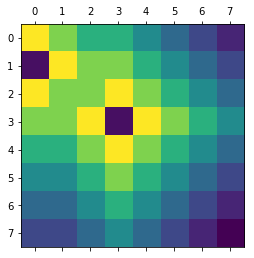

In [353]:
plt.matshow(env.pathplot(value_agent.V))
plt.show()

## Poilcy Iteration

In [347]:
class PolicyIteration(DiscreteAgent):
    def __init__(self,env):
        self.env = env
        self.gamma = 0.9
        self.Q = np.zeros((env.maxrow,env.maxcol,env.tot_act))
        self.V = np.zeros((env.maxrow,env.maxcol))
        self.policy = np.random.randint(env.tot_act,size=(env.maxrow,env.maxcol))
        self.policy_stable = False
    
    def update(self):
        while not self.policy_stable:
            self.policy_evaluation()
            self.policy_improvement()
    
    def policy_evaluation(self):
        eps = 1e-9
        while True:
            delta = 0
            for row in range(len(self.V)):
                for col in range(len(self.V[row])):
                    state=(row,col)
                    v = self.V[state]
                    self.env.set_start_state(state)
                    action = self.policy[state]
                    new_state,reward,done = self.env.step(action)
                    self.Q[state][action] = reward + \
                                            self.gamma * self.V[new_state]
                    self.V[state] = self.Q[state][action]
                    delta = max(delta,np.abs(v-self.V[state]))
                    
                           
            #print(self.V)
            #print(delta)
            
            if delta < (eps*(1-self.gamma))/(2*self.gamma):
                break
            
    def policy_improvement(self):
        self.policy_stable = True
        for row in range(len(self.V)):
            for col in range(len(self.V[row])):
                state=(row,col)
                v = self.V[state]
                for action in self.env.actions:
                    self.env.set_start_state(state)
                    new_state,reward,done = self.env.step(action)
                    self.Q[state][action] = reward + self.gamma * self.V[new_state]
                #if v != np.max(self.Q[state]):
                self.V[state] = np.max(self.Q[state])
                
                if np.argmax(self.Q[state]) != self.policy[state]:
                    self.policy[state] = np.argmax(self.Q[state])
                    self.policy_stable = False
        #print(self.V)
        self.env.pi_test(self.policy,self.V)
                    
    
    def get_action(self):
        pass

In [348]:
policy_agent  = PolicyIteration(env)
policy_agent.update()

In [349]:
print(policy_agent.policy)
print(policy_agent.V)

[[1 1 1 1 1 1 1 1]
 [0 2 2 1 1 1 1 1]
 [0 0 1 1 1 1 1 1]
 [0 3 3 0 2 2 2 2]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[[10.        8.        6.2       6.2       4.58      3.122     1.8098
   0.62882 ]
 [ 0.       10.        8.        8.        6.2       4.58      3.122
   1.8098  ]
 [10.        8.        8.       10.        8.        6.2       4.58
   3.122   ]
 [ 8.        8.       10.        0.       10.        8.        6.2
   4.58    ]
 [ 6.2       6.2       8.       10.        8.        6.2       4.58
   3.122   ]
 [ 4.58      4.58      6.2       8.        6.2       4.58      3.122
   1.8098  ]
 [ 3.122     3.122     4.58      6.2       4.58      3.122     1.8098
   0.62882 ]
 [ 1.8098    1.8098    3.122     4.58      3.122     1.8098    0.62882
  -0.434062]]


In [350]:
print('goal states = ',env.goal_states)
print('start states = ',env.start_states)

goal states =  [(3, 3), (1, 0)]
start states =  [(1, 6)]


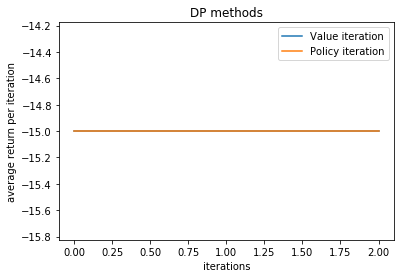

In [351]:
iteration_vi = list(range(0,len(env.vi_list)))
iteration_pi = list(range(0,len(env.pi_list)))
plt.plot(iteration_vi,env.vi_list,label='Value iteration')
plt.plot(iteration_pi,env.pi_list,label = 'Policy iteration')
plt.xlabel("iterations")
plt.ylabel("average return per iteration")
plt.title("DP methods")
plt.legend()
plt.show()

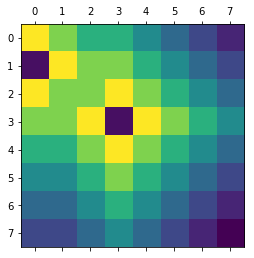

In [352]:
# Display matrix
plt.matshow(env.pathplot(policy_agent.V))
plt.show()

In [323]:
print(env.vi_list)
print(env.pi_list)

[-15.0, -15.0, -15.0, -15.0]
[-15.0, -15.0, -15.0, -15.0]


## 2. Car Rental

### A
$\textbf{States}$: It is given to us that there are maximum 20 cars in each location, let us call it X and Y. Let us denote maximum cars as $C_{max}$. And the problem is to find out how many cars do we have to have at each location so that the business never goes down, that is, number of cars on neither locations should be zero. Thus our state space then becomes number of cars available in location X $N_x$ and number of car available in location Y $N_y$. Thus our state space will be $N_x$ x $N_y$ where $N_x, N_y \in (0,20).$

$\textbf{Actions:}$ Since the number of cars could potentially become insufficient for future renters, we could move the cars from one location to the another overnight, with a limit of maximum 5 cars that can be transferred. Since 5 cars can be moved from either location we have total 11 actions inclusing no cars transferred. Thus, possible actions is $A \in (-5,5)$. $-5$ to  $-1$ denote cars transferred from location X to location Y.

$\textbf{Reward:}$ It is given that for every car rented the owner gets $\$$10 and for every car transferred, it costs the owner $\$$2. the reward is defined by $r_{s,s'}$ which is the reward for reaching a state s' from s. We also have $r'_{s,a}$ which is the reward for action taken given a state.   

$\textbf{Transition:}$ We require 4 different poisson distribution for request (cars rented) and returns (cars returned) from either locations. According to our problem, the returns and returns are taken randomly from the distribution.
Thus we have $P^{rental}_A, P^{rental}_B, P^{return}_A and P^{return}_A $ as our required probability. Thus given any action $\textit{a} \in A$, the transition probability is defined as $P^a_{ss'} =  \mathbb{P}[S_{t+1} = s'| S_t = s, A_t = a]$. Here s' is a tuple of (x,y) where x$\in C_{m}$ and $y \in {C_m}$. The transition probability can also be written as $P^a_{ss'} = P_x^{request}*P_y^{request} \sum_{x,y} P_x^{return}*P_y^{return}$

We will solve this problem using policy Iteration. Policy iteration consists of two steps:\
$1.  \textbf{  Policy Evaluation:}$
In policy evaluation we assume random actions for all states. At this point we consider it to be our optimal policy. We evaluate using the follwing bellman expectation operator: $Q_\pi(s,\pi(s)) =-r'_{s,\pi(s)} + \sum_{s'}P_{ss'}^{\pi(s)}[r_{s,s'}+\gamma V_\pi(s')]$. 

We use the above expectation to calculate expected reward for all states. Once the states converge to the current policy, we check if these are actually the optimal policy. We the follow the next step called the policy improvement. 
   
$2.  \textbf{  Policy Improvement:}$ Here we look for a better policy by running one iteration of state-action pair scan where for each state we evaluate all possible actions to see if there exists any policy that is better than the current policy. The updation of policy can be described as follows:\
$\hspace{8cm}\pi'(s) = argmax_{a}Q^{\pi}(s,a)$\
$\hspace{9cm}= argmax_{a}-r'_{s,a} + \sum_{s'}P_{ss'}^{a}[r_{s,s'}+\gamma V_\pi(s')]$


### B


In [486]:
class CarRental:
    def __init__(self,max_car_A,max_car_B):
        self.tot_act = 11
        self.maxrow = max_car_A+1
        self.maxcol = max_car_B+1
        self.car_A = max_car_A
        self.car_B = max_car_B
        self.actions = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
        self.pi_list = []
        self.P_rental,self.P_return = self.prepare_transition()
    
    def prepare_transition(self):
        P_rental = np.zeros((self.maxrow,self.maxcol))
        P_return = np.zeros((self.maxrow,self.maxcol))
        for i in range(0,self.maxrow): #request
            for j in range(0,self.maxrow): #return
                P_rental[i][j] = self.req_ret(3,i) * self.req_ret(4,j)
                P_return[i][j] = self.req_ret(3,i) * self.req_ret(2,j)
        return P_rental,P_return
            
                
    def req_ret(self,lamb,N):
        return poisson.pmf(N, lamb)

In [43]:
class PolicyIterationRental:
    def __init__(self,env):
        self.env = env
        self.gamma = 0.9
        self.Q = np.zeros((env.maxrow,env.maxcol,env.tot_act))
        self.V = np.zeros((env.maxrow,env.maxcol))
        #self.policy = np.random.randint(-5,6,size=(env.maxrow,env.maxcol))
        self.policy = np.zeros((env.maxrow,env.maxcol))
        self.policy_stable = False
    
    def update(self):
        while not self.policy_stable:
            self.policy_evaluation()
            self.policy_improvement()
    
    def policy_evaluation(self):
        print("Evaluation")
        eps = 1e-2
        iterations = 5
        while iterations:
        #while True:
            delta = 0
            for row in range(1,len(self.V)):
                for col in range(1,len(self.V[row])):
                    state=(row,col)
                    v = self.V[state]
                    #env.set_start_state(state)
                    action = int(self.policy[state])
                    self.Q[state][action] = self.calculate_return(action,state)
                    self.V[state] = self.Q[state][action]
                    delta = max(delta,np.abs(v-self.V[state]))
            #self.env.pi_test(self.policy,self.V)       
            #print(self.V)
            iterations-=1
            if delta < eps:
                break
            
    def calculate_return(self,action,present_state):
        action_cost = 2 * abs(action)
        total_return = 0
        for rental_A in range(len(self.env.P_rental)):
            for rental_B in range(len(self.env.P_rental[rental_A])):
                rental_state=(rental_A,rental_B)
                prob_rental = self.env.P_rental[rental_state]
                rental_cost = (rental_A + rental_B)*10
                
                for return_A in range(len(self.env.P_return)):
                    new_state_A = present_state[0] - rental_A + return_A - action
                    if new_state_A > self.env.car_A:
                        break
                        
                    elif new_state_A > 0:
                        for return_B in range(len(self.env.P_return[return_A])):
                            return_state = (return_A,return_B)
                            prob_return = self.env.P_return[return_state]

                            new_state_B = present_state[1] - rental_B + return_B + action

                            #print((new_state_A,new_state_B))

                            if new_state_B > self.env.car_B:
                                break
                            elif new_state_B > 0:
                                total_return+= prob_rental * prob_return * (rental_cost + \
                                               self.gamma * self.V[(new_state_A,new_state_B)]) 
        
        return (total_return - action_cost)
                 
                
    def policy_improvement(self):
        print("Improvement")
        self.policy_stable = True
        for row in range(1,len(self.V)):
            for col in range(1,len(self.V[row])):
                state=(row,col)
                v = self.V[state]
                for action in self.env.actions:
                    self.Q[state][action] = self.calculate_return(action,state)
                #if v != np.max(self.Q[state]):
                self.V[state] = np.max(self.Q[state])
                
                if np.argmax(self.Q[state]) != self.policy[state]:
                    self.policy[state] = np.argmax(self.Q[state])
                    self.policy_stable = False
        #print(self.V)
        #self.env.pi_test(self.policy,self.V)
                    
    
    def get_action(self):
        pass

In [44]:
env_rental = CarRental(20,20)
agent  = PolicyIterationRental(env_rental)
agent.update()

Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement
Evaluation
Improvement


In [265]:
#agent.policy
#np.savetxt('policy_CarRental.out', agent.policy)
#np.savetxt('StateValue_CarRental.out', agent.V)
rental_policy = np.loadtxt('policy_CarRental.out')
rental_value = np.loadtxt('StateValue_CarRental.out')

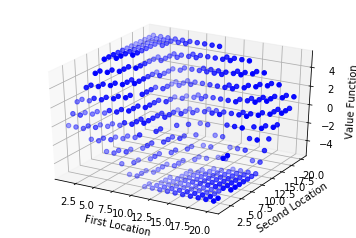

In [556]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = [i for i in range(1,21)]
for row in range(1,len(rental_value)):
    #xs = []#randrange(n, 23, 32)
    ys = [row]*len(xs)#randrange(n, 0, 100)
    zs = rental_policy[row]#randrange(n, zlow, zhigh)
    for j in range(len(zs)):
        if zs[j] == 10:
            zs[j] = -1
        elif zs[j] == 9:
            zs[j] = -2
        elif zs[j] == 8:
            zs[j] = -3
        elif zs[j] == 7:
            zs[j] = -4
        elif zs[j] == 6:
            zs[j] = -5
    #print(zs)
    zs = zs[1:]
    ax.scatter(xs,ys,zs, marker='o',c='b')

ax.set_xlabel('First Location')
ax.set_ylabel('Second Location')
ax.set_zlabel('Value Function')

plt.show()

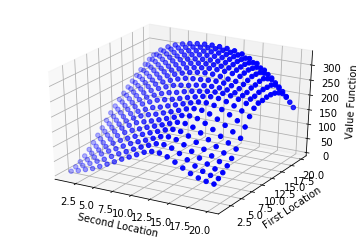

In [285]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = [i for i in range(1,21)]
for row in range(1,len(rental_value)):
    #xs = []#randrange(n, 23, 32)
    ys = [row]*len(xs)#randrange(n, 0, 100)
    zs = rental_value[row]#randrange(n, zlow, zhigh)
    zs = zs[1:]
    ax.scatter(xs, ys, zs, marker='o',c='b')

ax.set_xlabel('Second Location')
ax.set_ylabel('First Location')
ax.set_zlabel('Value Function')

plt.show()

## Gambling

In [455]:
class Gamble:
    def __init__(self,p):
        #self.maxrow = r
        self.maxcol = 101
        self.tot_act = 51
        self.actions = [i for i in range(1,self.tot_act)]
        self.vi_list = []
        self.p = p
        self.P = [self.p,1-self.p]

In [544]:
class ValueIterationGamble:
    def __init__(self,env):
        self.env = env
        #self.gamma = 0.9
        self.Q = np.zeros((env.maxcol,env.tot_act))
        self.V = np.zeros((101))
        self.policy = np.zeros((101))
        self.V_cache = {}
        self.iterations = 500
        
    def update(self):
        
        eps = 1e-12
        itr = 1
        while itr: #<= self.iterations:
            delta = 0
            for state in range(0,len(self.V)):
                #print(state)
                v = self.V[state]
                limit = min(state,100-state)
                if limit == 0:
                    continue
                for action in self.env.actions:
                    #self.env.set_start_state(state)
                    #new_state,reward,done = self.env.step(action)
                    #print(reward)
                    self.Q[state][action] = self.calculate_reward(action,state)
                    if action == limit:
                        break
                self.V[state] = np.max(self.Q[state])
                delta = max(delta,abs(v-self.V[state]))
                #print(delta)
            
            self.V_cache[itr] = self.V.copy()
            #print(delta)
            if delta < eps:
                break
            itr += 1
                
        self.plot(itr)
        #print(self.V)
        #self.env.vi_test(self.Q)
    
    def calculate_reward(self,action,state):
        return_tot = 0
        state_prime = [state+action,state-action]
        
        for i in range(len(state_prime)):
            if state_prime[i] == 100:
                reward = 1
            else:
                reward = 0
            return_tot += self.env.P[i] * (reward + self.V[state_prime[i]]) 
        
        return return_tot
    
    def get_best_policy(self):
        for row in range(1,len(self.Q)-1): #1-99 states
            self.policy[row] = np.argmax(self.Q[row])
            
    def plot(self,itr):
        capital = [i for i in range(1,100)]
        #for i in self.V_cache:
        plt.plot(capital,self.V_cache[1][1:-1],label='Sweep '+str(1))
        plt.plot(capital,self.V_cache[2][1:-1],label='Sweep '+str(2))
        plt.plot(capital,self.V_cache[3][1:-1],label='Sweep '+str(3))
        plt.plot(capital,self.V_cache[itr][1:-1],label='Sweep '+str(itr))
        #plt.axis([1,99,0,1])
        plt.xlabel("capital")
        plt.ylabel("value estimates")
        plt.title("Gambling (Value Iteration)")
        plt.legend()
        plt.show()
            
    def get_action(self):
        pass

P =  0.15


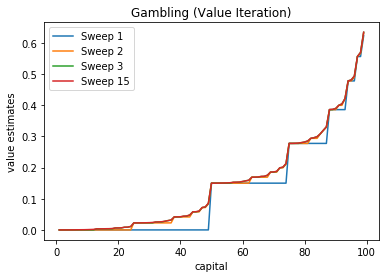

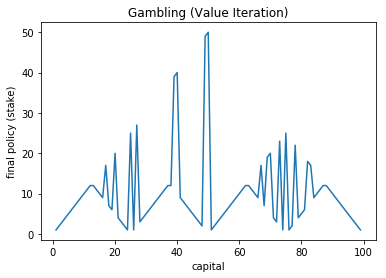

P =  0.65


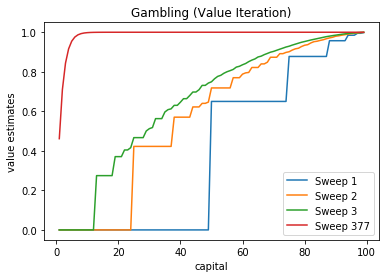

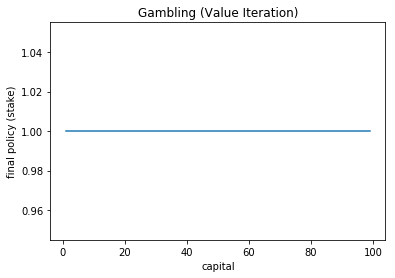

In [548]:
tests = [0.15,0.65]
for p in tests:
    env_gamble =  Gamble(p)
    agent_gamble = ValueIterationGamble(env_gamble)
    print('P = ',p)
    agent_gamble.update()
    agent_gamble.get_best_policy()
    #plot
    
    '''
    capital = [i for i in range(1,100)]
    plt.plot(capital,agent_gamble.V[1:-1],label='Final sweep ')
    #plt.axis([1,99,0,1])
    plt.xlabel("capital")
    plt.ylabel("value estimates")
    plt.title("Gambling (Value Iteration)")
    plt.legend()
    plt.show()
    '''
    
    plt.plot(capital,agent_gamble.policy[1:-1])
    #plt.axis([1,99,1,50])
    plt.xlabel("capital")
    plt.ylabel("final policy (stake)")
    plt.title("Gambling (Value Iteration)")
    plt.show()
